In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

Matplotlib is building the font cache; this may take a moment.


# Colocation Maps

This dataset helps us identify where people colocated for every week. 

In [3]:
df = pd.read_csv('../../data/movement/meta/colocation_maps/9377133743227176_2024-05-20.csv')

In [21]:
niger_adm0 = gpd.read_file('../../data/shapefiles/ner_adm_ignn_20230720_ab_shp/NER_admbnda_adm0_IGNN_20230720.shp')
niger_adm1 = gpd.read_file('../../data/shapefiles/ner_adm_ignn_20230720_ab_shp/NER_admbnda_adm1_IGNN_20230720.shp')
niger_adm2 = gpd.read_file('../../data/shapefiles/ner_adm_ignn_20230720_ab_shp/NER_admbnda_adm2_IGNN_20230720.shp')

In [40]:
niger_gadm = gpd.read_file('../../data/shapefiles/gadm/gadm41_NER_2.json')

In [135]:
libya = gpd.read_file('../../data/shapefiles/libya/lby_admbnda_adm0_unosat_lbsc_20180507.shp')
nigeria = gpd.read_file('../../data/shapefiles/nigeria/nga_admbnda_adm0_osgof_20190417.shp')
algeria = gpd.read_file('../../data/shapefiles/algeria/dza_admbnda_adm0_unhcr_20200120.shp')
chad = gpd.read_file('../../data/shapefiles/chad/tcd_admbnda_adm0_ocha.shp')
mali = gpd.read_file('../../data/shapefiles/mali/mli_admbnda_adm0_1m_gov_20211220.shp')
burkinafaso = gpd.read_file('../../data/shapefiles/burkinafaso/bfa_admbnda_adm0_igb_20200323.shp')

In [137]:
neighbors = pd.concat([libya, mali, chad, algeria, nigeria, burkinafaso])

In [9]:
aoi =['NER','NGA', 'MLI', 'BFA', 'TCD', 'DZA', 'BEN', 'LBY' ]

In [13]:
df = df[df['country'].isin(aoi)]

In [33]:
niger = df[df['country'].isin(['NER'])]

array(['Tillabéry', 'Keita', 'Dosso', 'Madaoua', 'Tchighozerine',
       'Bkonni', 'Mirriah', 'Madarounfa', 'Tanout', 'Tahoua', 'Boboye',
       'Niamey', 'Groumdji', "N'Guigmi", 'Aguié', 'Magaria', 'Kollo',
       'Gouré', 'Loga', 'Gaya', 'Arlit', 'Tchin-Tabarade', 'Ouallam',
       'Dogon-Doutchi', 'Illéla', 'Maïné-Soroa', 'Dakoro', 'Say',
       'Filingué', 'Bilma', 'Bouza', 'Diffa', 'Tessaoua', 'Matameye',
       'Téra', 'Mayahi'], dtype=object)

In [51]:
niger = niger.merge(niger_gadm[['GID_2', 'centroid']], left_on='polygon1_id', right_on='GID_2')
niger.rename(columns={'centroid':'source_centroid'}, inplace=True)

In [52]:
niger = niger.merge(niger_gadm[['GID_2', 'centroid']], left_on='polygon2_id', right_on='GID_2')
niger.rename(columns={'centroid':'target_centroid'}, inplace=True)

In [54]:
niger.drop(columns = ['GID_2_x', 'GID_2_y'], inplace=True)

In [64]:
niger['source_lat']= niger['source_centroid'].apply(lambda p: p.x)
niger['source_lon']= niger['source_centroid'].apply(lambda p: p.y)

niger['target_lat']= niger['target_centroid'].apply(lambda p: p.x)
niger['target_lon']= niger['target_centroid'].apply(lambda p: p.y)

In [66]:
niger.to_csv('../../data/movement/meta/colocation_niger.csv')

In [115]:
commuting_zones = pd.read_excel('../../data/movement/meta/commuting_zones/commuting_zones_niger.xlsx')

<iframe width="100%" height="500px" src="https://studio.foursquare.com/map/public/a9710c29-d74d-43c6-a907-b4f9e8d7050c/embed" frameborder="0" allowfullscreen></iframe>

# Commuting Zones

In [116]:
from shapely.wkt import loads
from shapely.geometry import Polygon

# WKT representation of the Polygon

# Create a Polygon geometry object from the WKT representation
commuting_zones['geometry'] = commuting_zones['GEOMETRY'].apply(lambda x: loads(x))

# Now, 'polygon' contains the Polygon geometry object


In [117]:
commuting_zones = gpd.GeoDataFrame(commuting_zones, geometry='geometry')

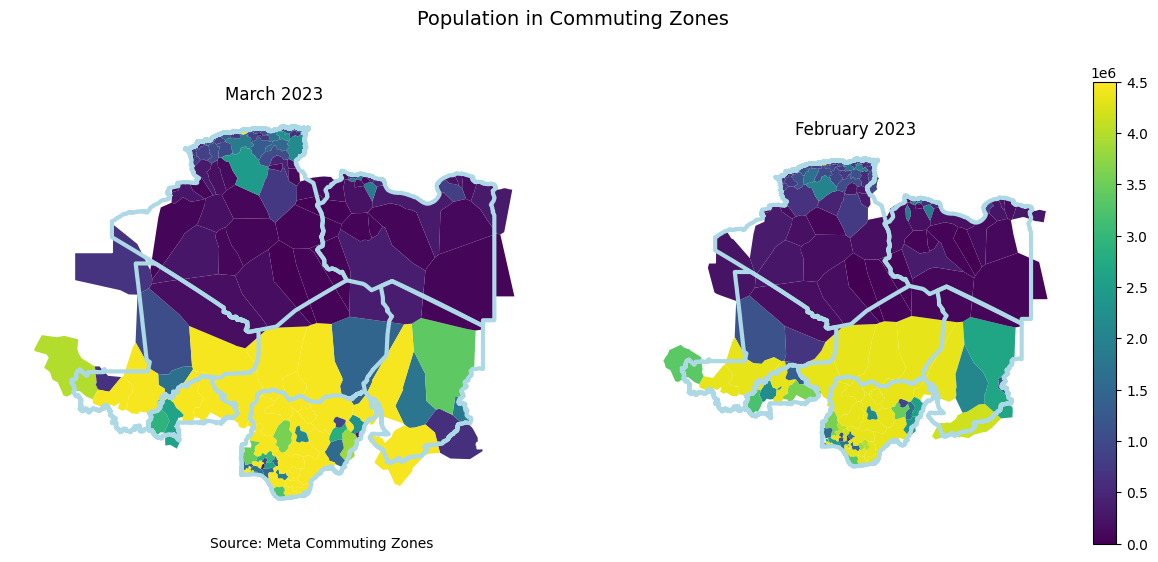

In [237]:
import matplotlib.colors as mcolors

fig, ax = plt.subplots(1,2, figsize=(15,6))
axs=ax.flatten()
neighbors.boundary.plot(ax=ax[0], color='lightblue', linewidth=3)
commuting_zones[commuting_zones['ds']=='2023-03-05'].plot(ax=ax[0], column='win_population', cmap='viridis', vmin=0, vmax=4500000)
#niger_adm0.plot(ax=ax[0], color='orange', alpha = 0.5)
ax[0].set_title('March 2023')

neighbors.boundary.plot(ax=ax[1], color='lightblue', linewidth=3)
im = commuting_zones[commuting_zones['ds']=='2024-02-04'].plot(ax=ax[1], column='win_population', cmap='viridis', vmin=0, vmax=4500000, legend=True)
#niger_adm0.plot(ax=ax[1], color='orange', alpha = 0.5)
ax[1].set_title('February 2023')

# Remove colorbar
# plt.colorbar(im).remove()

# # Plot colorbar with custom size
# cbar = plt.colorbar(im, ax=ax[1], shrink=0.5)  # Adjust shrink parameter for size
# cbar.ax.tick_params(labelsize=10)  # Adjust label font size

#colorbar = plt.colorbar(im)
#colorbar.figure.set_size_inches(2, 2)

#cbar = fig.colorbar(im, ax=ax[1])

for i in [0,1]:
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)

ax[0].text(0,0,'Source: Meta Commuting Zones')

plt.suptitle('Population in Commuting Zones', x=0.5, y=1, fontsize=14);


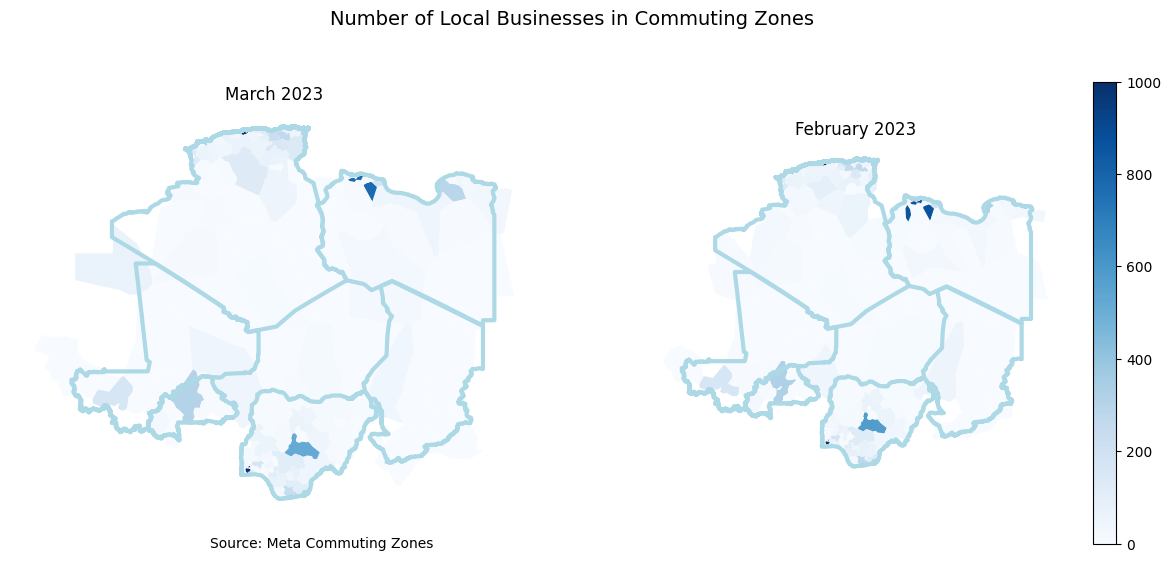

In [235]:
import matplotlib.colors as mcolors

fig, ax = plt.subplots(1,2, figsize=(15,6))
axs=ax.flatten()
neighbors.boundary.plot(ax=ax[0], color='lightblue', linewidth=3)
commuting_zones[commuting_zones['ds']=='2023-03-05'].plot(ax=ax[0], column='local_business_locations_count', cmap='Blues',  vmin=0, vmax=1000)
#niger_adm0.plot(ax=ax[0], color='orange', alpha = 0.5)
ax[0].set_title('March 2023')

neighbors.boundary.plot(ax=ax[1], color='lightblue', linewidth=3)
im = commuting_zones[commuting_zones['ds']=='2024-02-04'].plot(ax=ax[1], column='local_business_locations_count', cmap='Blues', vmin=0, vmax=1000, legend=True)
#niger_adm0.plot(ax=ax[1], color='orange', alpha = 0.5)
ax[1].set_title('February 2023')

# Remove colorbar
# plt.colorbar(im).remove()

# # Plot colorbar with custom size
# cbar = plt.colorbar(im, ax=ax[1], shrink=0.5)  # Adjust shrink parameter for size
# cbar.ax.tick_params(labelsize=10)  # Adjust label font size

#colorbar = plt.colorbar(im)
#colorbar.figure.set_size_inches(2, 2)

#cbar = fig.colorbar(im, ax=ax[1])

for i in [0,1]:
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)

ax[0].text(0,0,'Source: Meta Commuting Zones')

plt.suptitle('Number of Local Businesses in Commuting Zones', x=0.5, y=1, fontsize=14);
